# Using sequence divergence features to predict "Functional Divergence" 

Based on fet_ppi_overlap value of:
https://www.sciencedirect.com/science/article/pii/S240547122100329X?via%3Dihub

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Prepare data, load and merge

In [3]:
# File path of datasets
fn_kg_features = Path('/Users/olivierdennler/Documents/data/SLI_2023/paralog_SL_prediction-master/local_data/processed/paralog_features/all_features.csv').resolve()
fn_CONT_features_pairs = Path('/Users/olivierdennler/Documents/data/SLI_2023/contW_foldseek/ens111_foldseek_nonInf.csv').resolve()
fn_gogo_features_pairs = Path('/Users/olivierdennler/Documents/data/SLI_2023/GO/gogo_ens111_human_data.csv').resolve()
fn_seq_features_pairs = Path('/Users/olivierdennler/Documents/data/SLI_2023/contW_mmseqs2/ens111_cont-seq-Human-ensembl-score.csv').resolve()
fn_esm2_pairs = Path('/Users/olivierdennler/Documents/data/SLI_2023/embeddings_hs/esm2_embeddings_pair_distances.csv').resolve()
fn_ProtT5_pairs = Path('/Users/olivierdennler/Documents/data/SLI_2023/embeddings_hs/ens111_human_embeddings_ProtT5_distances.csv').resolve()

# Build dataframes from input files and merge them

# All features data
paralog_pairs = pd.read_csv(fn_kg_features)
 
# Context-wise annotations
cont_paralog_annotations = pd.read_csv(fn_CONT_features_pairs, sep=',', on_bad_lines='skip', float_precision="round_trip", keep_default_na=False, na_values=['NA_hit', '','NaN','None','NA_aln'])
print('Context-Wise annotated pairs:', cont_paralog_annotations.shape[0])

# Sequence Context-wise annotations
seq_cont_paralog_annotations = pd.read_csv(fn_seq_features_pairs, float_precision="round_trip", keep_default_na=False, na_values=['NA_hit', '','NaN','None','NA_aln'])
print('Sequence Context-Wise annotated pairs:', cont_paralog_annotations.shape[0])
    
# ESM2 embedding distances annotations
# Create a set of unique values from depmap_pairs for efficient lookup
unique_gene_pairs = set(paralog_pairs['sorted_gene_pair'])
# Set up an empty DataFrame to store filtered data
filtered_data = pd.DataFrame()
# Adjust the chunk size based on your memory capacity
chunk_size = 100000
for chunk in pd.read_csv(fn_esm2_pairs, chunksize=chunk_size, keep_default_na=False):
    # Filter the chunk to keep only rows present in the unique_gene_pairs set
    filtered_chunk = chunk[chunk['sorted_gene_pair'].isin(unique_gene_pairs)]
    # Concatenate the filtered chunk to the filtered_data DataFrame
    filtered_data = pd.concat([filtered_data, filtered_chunk])
# Assign the filtered and renamed data to esm2_paralog_annotations
esm2_paralog_annotations = filtered_data
print('ESM2 distances annotated pairs:', esm2_paralog_annotations.shape[0])

# ProtT5 embedding distances annotations
protT5_paralog_annotations = pd.read_csv(fn_ProtT5_pairs, keep_default_na=False)
print('ProtT5 (Uniprot) distances annotated pairs:', protT5_paralog_annotations.shape[0])


# Merging
print('Num pairs (before merging):', paralog_pairs.shape[0])

paralog_pairs = pd.merge(paralog_pairs, cont_paralog_annotations, how='left', on='sorted_gene_pair', suffixes=('', '_y'))
paralog_pairs.drop(paralog_pairs.filter(regex='_y$').columns, axis=1, inplace=True)
print('Num pairs (after merging with merging struct. context. annot.):', paralog_pairs.shape[0])

paralog_pairs = pd.merge(paralog_pairs, seq_cont_paralog_annotations, how='left', on='sorted_gene_pair', suffixes=('', '_y'))
paralog_pairs.drop(paralog_pairs.filter(regex='_y$').columns, axis=1, inplace=True)
print('Num pairs (after merging with seq. context. annot.):', paralog_pairs.shape[0])

paralog_pairs = pd.merge(paralog_pairs, esm2_paralog_annotations, how='left', on='sorted_gene_pair', suffixes=('', '_y'))
paralog_pairs.drop(paralog_pairs.filter(regex='_y$').columns, axis=1, inplace=True)
print('Num pairs (after merging with ESM2):', paralog_pairs.shape[0])

paralog_pairs = pd.merge(paralog_pairs, protT5_paralog_annotations, how='left', on='sorted_gene_pair', suffixes=('', '_y'))
paralog_pairs.drop(paralog_pairs.filter(regex='_y$').columns, axis=1, inplace=True)
print('Num pairs (after merging with ProtT5):', paralog_pairs.shape[0])

paralog_pairs

Context-Wise annotated pairs: 123827
Sequence Context-Wise annotated pairs: 123827
ESM2 distances annotated pairs: 121376
ProtT5 (Uniprot) distances annotated pairs: 123741
Num pairs (before merging): 123827
Num pairs (after merging with merging struct. context. annot.): 123827
Num pairs (after merging with seq. context. annot.): 123827
Num pairs (after merging with ESM2): 123827
Num pairs (after merging with ProtT5): 123827


,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,esm2_mean_of_residue_tokens_manhattan,esm2_mean_of_residue_tokens_ts_ss,esm2_mean_of_special_tokens_cosine,esm2_mean_of_special_tokens_euclidean,esm2_mean_of_special_tokens_manhattan,esm2_mean_of_special_tokens_ts_ss,ProtT5_per-protein_cosine,ProtT5_per-protein_euclidean,ProtT5_per-protein_manhattan,ProtT5_per-protein_ts_ss
0,A1BG_FCAR,A1BG,FCAR,ENSG00000121410,ENSG00000186431,1,2204,False,0.094950,0.163763,...,228.636890,2.157836,0.074568,4.301157,243.543914,3.262672,0.163086,0.7983,20.420,0.002858
1,A1BG_GP6,A1BG,GP6,ENSG00000121410,ENSG00000088053,1,51206,False,0.103226,0.129293,...,264.279069,3.145699,0.089152,4.719659,267.355491,4.262900,0.171387,0.8530,21.580,0.004326
2,FCAR_GP6,FCAR,GP6,ENSG00000186431,ENSG00000088053,2204,51206,False,0.146774,0.317073,...,227.255365,2.038136,0.019469,2.189520,124.847434,0.378296,0.098145,0.6416,16.110,0.001711
3,A1BG_IGSF1,A1BG,IGSF1,ENSG00000121410,ENSG00000147255,1,3547,False,0.071108,0.191919,...,156.761353,0.541372,0.079487,4.511212,256.038340,3.851121,0.195312,0.9595,23.480,0.007836
4,FCAR_IGSF1,FCAR,IGSF1,ENSG00000186431,ENSG00000147255,2204,3547,False,0.068862,0.320557,...,168.061892,0.826491,0.023999,2.482612,139.966594,0.670824,0.227051,1.0300,24.980,0.009743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123822,ZSWIM4_ZSWIM6,ZSWIM4,ZSWIM6,ENSG00000132003,ENSG00000130449,65249,57688,False,0.577778,0.634720,...,110.900215,0.177133,0.009643,1.580465,89.257890,0.153981,0.082031,0.4670,11.695,0.000469
123823,ZSWIM5_ZSWIM6,ZSWIM5,ZSWIM6,ENSG00000162415,ENSG00000130449,57643,57688,True,0.707819,0.725738,...,63.448792,0.028264,0.003172,0.908086,51.827745,0.031436,0.019043,0.2524,6.383,0.000064
123824,ZSWIM4_ZSWIM8,ZSWIM4,ZSWIM8,ENSG00000132003,ENSG00000214655,65249,23053,False,0.178844,0.296564,...,200.092784,1.870456,0.095384,4.967618,277.680310,5.187456,0.145996,0.6133,15.170,0.001146
123825,ZSWIM5_ZSWIM8,ZSWIM5,ZSWIM8,ENSG00000162415,ENSG00000214655,57643,23053,False,0.178299,0.275949,...,202.950143,1.960636,0.081628,4.610164,258.407709,3.931654,0.132324,0.5880,14.510,0.000940


## Features post treatment for Context-Wise
i.e., reduction of the 2 ways in 1 feature

In [4]:
# Convert the columns to numeric
for column in paralog_pairs.columns:
    paralog_pairs[column] = pd.to_numeric(paralog_pairs[column], errors='ignore')

# Create new features as the minimum of pairs
paralog_pairs['rank_struct'] = paralog_pairs[['A1_A2_rank', 'A2_A1_rank']].min(axis=1)
paralog_pairs['selfSP_struct'] = paralog_pairs[['A1_nb_human', 'A2_nb_human']].min(axis=1)
paralog_pairs['taxid_struct'] = paralog_pairs[['A1_nb_taxid', 'A2_nb_taxid']].min(axis=1)
paralog_pairs['bits_struct'] = paralog_pairs[['A1_bits', 'A2_bits']].min(axis=1)
paralog_pairs['fident_struct'] = paralog_pairs[['A1_fident', 'A2_fident']].min(axis=1)
paralog_pairs['alnlen_struct'] = paralog_pairs[['A1_alnlen', 'A2_alnlen']].min(axis=1)
paralog_pairs['evalue_struct'] = paralog_pairs[['A1_evalue', 'A2_evalue']].min(axis=1)
paralog_pairs['alntmscore_struct'] = paralog_pairs[['A1_alntmscore', 'A2_alntmscore']].min(axis=1)
paralog_pairs['qtmscore_struct'] = paralog_pairs[['A1_qtmscore', 'A2_qtmscore']].min(axis=1)
paralog_pairs['ttmscore_struct'] = paralog_pairs[['A1_ttmscore', 'A2_ttmscore']].min(axis=1)
paralog_pairs['prob_struct'] = paralog_pairs[['A1_prob', 'A2_prob']].min(axis=1)
paralog_pairs['lddt_struct'] = paralog_pairs[['A1_lddt', 'A2_lddt']].min(axis=1)

# Create new features as the minimum of pairs
paralog_pairs['rank_seq'] = paralog_pairs[['A1_A2_rank_seq', 'A2_A1_rank_seq']].min(axis=1)
paralog_pairs['selfSP_seq'] = paralog_pairs[['A1_nb_selfSP_seq', 'A2_nb_selfSP_seq']].min(axis=1)
paralog_pairs['taxid_seq'] = paralog_pairs[['A1_nb_taxid_seq', 'A2_nb_taxid_seq']].min(axis=1)
paralog_pairs['bits_seq'] = paralog_pairs[['A1_A2_bits_seq', 'A2_A1_bits_seq']].min(axis=1)
paralog_pairs['id_percent_seq'] = paralog_pairs[['A1_A2_id_percent_seq', 'A2_A1_id_percent_seq']].min(axis=1)
paralog_pairs['evalue_seq'] = paralog_pairs[['A1_evalue_seq', 'A2_evalue_seq']].min(axis=1)

# Let's check the first few rows of the dataset again
paralog_pairs[:1]

/var/folders/3q/2xywjjx10gz19vlr9tn3r25m0000gn/T/ipykernel_78132/767219704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  paralog_pairs['rank_struct'] = paralog_pairs[['A1_A2_rank', 'A2_A1_rank']].min(axis=1)
/var/folders/3q/2xywjjx10gz19vlr9tn3r25m0000gn/T/ipykernel_78132/767219704.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  paralog_pairs['selfSP_struct'] = paralog_pairs[['A1_nb_human', 'A2_nb_human']].min(axis=1)
/var/folders/3q/2xywjjx10gz19vlr9tn3r25m0000gn/T/ipykernel_78132/767219704.py:8: PerformanceWarning: D

,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,qtmscore_struct,ttmscore_struct,prob_struct,lddt_struct,rank_seq,selfSP_seq,taxid_seq,bits_seq,id_percent_seq,evalue_seq
0,A1BG_FCAR,A1BG,FCAR,ENSG00000121410,ENSG00000186431,1,2204,False,0.09495,0.163763,...,0.1752,0.2921,1.0,0.5846,NaN,NaN,NaN,NaN,NaN,NaN


## Drop Na

Note that:

- Context NaN are replaced by min/max depending of the type of features

- paloma features produces 14857 NaN, corresponding to 1 family with 14857 members (see paloma notebook)


In [5]:
features = ['rank_struct', 'selfSP_struct', 'taxid_struct', 
            'fident_struct', 'bits_struct', 'alntmscore_struct', 'qtmscore_struct','ttmscore_struct',
            'alnlen_struct', 'evalue_struct', 'prob_struct', 'lddt_struct',
            'rank_seq', 'selfSP_seq', 'taxid_seq', 'bits_seq', 'id_percent_seq', 'evalue_seq',
            'esm2_beginning_of_sequence_cosine','esm2_beginning_of_sequence_euclidean','esm2_beginning_of_sequence_manhattan',
            'esm2_beginning_of_sequence_ts_ss','esm2_end_of_sequence_cosine','esm2_end_of_sequence_euclidean',
            'esm2_end_of_sequence_manhattan','esm2_end_of_sequence_ts_ss','esm2_mean_of_residue_tokens_cosine',
            'esm2_mean_of_residue_tokens_euclidean','esm2_mean_of_residue_tokens_manhattan','esm2_mean_of_residue_tokens_ts_ss',
            'esm2_mean_of_special_tokens_cosine','esm2_mean_of_special_tokens_euclidean','esm2_mean_of_special_tokens_manhattan',
            'esm2_mean_of_special_tokens_ts_ss',
            'ProtT5_per-protein_cosine', 'ProtT5_per-protein_euclidean', 'ProtT5_per-protein_manhattan', 'ProtT5_per-protein_ts_ss',
            ]


print(f"Initial number of rows in paralog pair table: {paralog_pairs.shape[0]}")
# Ensure that all feature names are in depmap_pairs columns
assert all(feature in paralog_pairs.columns for feature in features), "Some features are not in depmap_pairs columns"

# Calculate rows_with_nan before any dropna operation
rows_with_nan = paralog_pairs[features].isna().any(axis=1)
# Store these rows separately
rows_to_discard = paralog_pairs[rows_with_nan]
# Print the number of rows with NaN
print(f"Number of rows with NaN: {len(rows_to_discard)}")

nan_distribution = paralog_pairs[features].isna().sum()
nan_distribution_with_values = nan_distribution[nan_distribution > 0]
print(nan_distribution_with_values)

# Drop rows with NaN in depmap_pairs
paralog_pairs = paralog_pairs.dropna(subset=features)

# Print the number of rows after dropping NaN
print(f"Number of rows after dropping NaN: {paralog_pairs.shape[0]}")

Initial number of rows in paralog pair table: 123827
Number of rows with NaN: 19524
rank_struct                               4263
selfSP_struct                             4263
taxid_struct                              4263
fident_struct                             4263
bits_struct                               4263
alntmscore_struct                         4263
qtmscore_struct                           4263
ttmscore_struct                           4263
alnlen_struct                             4263
evalue_struct                             4263
prob_struct                               4263
lddt_struct                               4263
rank_seq                                 16370
selfSP_seq                               16370
taxid_seq                                16370
bits_seq                                 16370
id_percent_seq                           16370
evalue_seq                               16370
esm2_beginning_of_sequence_cosine         2451
esm2_beginning_of_seque

In [6]:
# All news sequences and structures features to model sequence divergence + min. sequence identity
news_features = ['min_sequence_identity',
                'rank_struct', 'selfSP_struct', 'taxid_struct', 
                'fident_struct', 'bits_struct', 'alntmscore_struct', 'qtmscore_struct','ttmscore_struct',
                'alnlen_struct', 'evalue_struct', 'prob_struct', 'lddt_struct',
                'rank_seq', 'selfSP_seq', 'taxid_seq', 
                'esm2_beginning_of_sequence_cosine','esm2_beginning_of_sequence_euclidean','esm2_beginning_of_sequence_manhattan',
                'esm2_beginning_of_sequence_ts_ss','esm2_end_of_sequence_cosine','esm2_end_of_sequence_euclidean',
                'esm2_end_of_sequence_manhattan','esm2_end_of_sequence_ts_ss','esm2_mean_of_residue_tokens_cosine',
                'esm2_mean_of_residue_tokens_euclidean','esm2_mean_of_residue_tokens_manhattan','esm2_mean_of_residue_tokens_ts_ss',
                'esm2_mean_of_special_tokens_cosine','esm2_mean_of_special_tokens_euclidean','esm2_mean_of_special_tokens_manhattan',
                'esm2_mean_of_special_tokens_ts_ss',
                'ProtT5_per-protein_cosine', 'ProtT5_per-protein_euclidean', 'ProtT5_per-protein_manhattan', 'ProtT5_per-protein_ts_ss',
                    ]

def latent_variable_pca(df):
    # Selecting the features you're interested in
    features_to_use = news_features
    # Extracting the features from the dataset
    X = df[features_to_use]
    # Standardizing the features
    X_standardized = StandardScaler().fit_transform(X)
    # Applying PCA
    pca = PCA(n_components=2) # We want to reduce to 1 dimension
    principalComponents = pca.fit_transform(X_standardized)
    # Adding the principal component as a new feature in the dataset
    df['dim1_PCA'] = principalComponents[:, 0]
    # Now depmap_pairs has an additional column 'Nseq_simil' representing the new feature
    return df

# Add latent variable
paralog_pairs = latent_variable_pca(paralog_pairs)

/var/folders/3q/2xywjjx10gz19vlr9tn3r25m0000gn/T/ipykernel_78132/1200755036.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['dim1_PCA'] = principalComponents[:, 0]
/var/folders/3q/2xywjjx10gz19vlr9tn3r25m0000gn/T/ipykernel_78132/1200755036.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dim1_PCA'] = principalComponents[:, 0]


In [7]:
# Save all paralog pairs with all features
paralog_pairs.to_csv('ens111_human_allFeatures.csv', index=False)

## Feature Correlations

In [19]:
# Define the heatmap function
def heatmap(x, y, fig_size, size, scale, color, x_labels, y_labels, feature_labels):
    #fig = plt.figure(figsize=(12, 12)) # PLM
    #fig = plt.figure(figsize=(4, 4)) # Simil search
    #fig = plt.figure(figsize=(10, 10)) # IntraFam search
    # scale = 700

    fig = plt.figure(figsize=(int(fig_size), int(fig_size)))
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) 
    ax = plt.subplot(plot_grid[:,:-1]) 
    
    # Mapping from column names to integer coordinates
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = int(scale)
    
    # Define sequential red color map
    #cmap = plt.cm.Reds
    cmap = plt.cm.viridis
    
    def value_to_color(val):
        norm = plt.Normalize(0, 1)
        return cmap(norm(val))

    # Mask upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    for (i, j, corr_value) in zip(x.map(x_to_num), y.map(y_to_num), color):
        if not mask[j, i]:  # Only plot the lower triangle
            ax.scatter(
                x=[i],
                y=[j],
                #s=[size_scale * abs(corr_value)], #for size coeff
                s = size_scale,
                c=[value_to_color(abs(corr_value))],
                marker='s'
            )
            text_color = 'white' if abs(corr_value) < 0.3 else 'black'
            ax.text(i, j, f"{corr_value:.2f}", color=text_color, ha='center', va='center', size=12)

    ax.set_xticks([x_to_num[v] for v in x_labels])
    #ax.set_xticklabels([feature_labels[v] for v in x_labels], rotation=45, horizontalalignment='right', size=15)
    ax.set_xticklabels([feature_labels[v] if v != x_labels[-1] else '' for v in x_labels], rotation=45, horizontalalignment='right', size=15)
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels([feature_labels[v] for v in y_labels], size=15)
    ax.grid(False)  # Hide the grid
    #ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    #ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.invert_yaxis()  # Ensure the single value line is on top and all values line is on the bottom
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) 
    col_x = [0]*256
    bar_y = np.linspace(0, 1, 256)  # Use 256 colors for smooth gradient
    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*256,
        left=col_x,
        height=bar_height,
        color=cmap(np.linspace(0, 1, 256)),
        linewidth=0
    )
    ax.set_xlim(1, 2)
    ax.grid(False)
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks(np.linspace(0, 1, 5))  # 5 ticks for simplicity
    ax.set_yticklabels([f'{i/4:.2f}' for i in range(5)])
    ax.yaxis.tick_right()

    # Color chart categories borders
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Define feature labels / "beautiful" names
feature_labels = {
    'min_sequence_identity': 'Min. Seq. Identity',
    'alnlen_struct': 'Aln length',
    'prob_struct': 'Probability',
    'bits_struct': 'Bits score',
    'evalue_struct': 'e-value',
    'lddt_struct': 'LDDT',
    'qtmscore_struct': 'TM-score (query)',
    'ttmscore_struct': 'TM-score (target)',
    'alntmscore_struct': 'TM-score (aln)',
    'fident_struct': 'fident',
    'esm2_beginning_of_sequence_cosine': 'ESM2 bs cos',
    'esm2_beginning_of_sequence_euclidean': 'ESM2 bs eucl',
    'esm2_beginning_of_sequence_manhattan': 'ESM2 bs manh',
    'esm2_beginning_of_sequence_ts_ss': 'ESM2 bs ts-ss',
    'esm2_end_of_sequence_cosine': 'ESM2 es cos',
    'esm2_end_of_sequence_euclidean': 'ESM2 es eucl',
    'esm2_end_of_sequence_manhattan': 'ESM2 es manh',
    'esm2_end_of_sequence_ts_ss': 'ESM2 es ts-ss',
    'esm2_mean_of_residue_tokens_cosine': 'ESM2 mrt cos',
    'esm2_mean_of_residue_tokens_euclidean': 'ESM2 mrt eucl',
    'esm2_mean_of_residue_tokens_manhattan': 'ESM2 mrt manh',
    'esm2_mean_of_residue_tokens_ts_ss': 'ESM2 mrt ts-ss',
    'esm2_mean_of_special_tokens_cosine': 'ESM2 mst cos',
    'esm2_mean_of_special_tokens_euclidean': 'ESM2 mst eucl',
    'esm2_mean_of_special_tokens_manhattan': 'ESM2 mst manh',
    'esm2_mean_of_special_tokens_ts_ss': 'ESM2 mst ts-ss',
    'ProtT5_per-protein_cosine': 'ProtT5 pp cos',
    'ProtT5_per-protein_euclidean': 'ProtT5 pp eucl',
    'ProtT5_per-protein_manhattan': 'ProtT5 pp manh',
    'ProtT5_per-protein_ts_ss': 'ProtT5 pp ts-ss',
    'rank_struct': 'Rank (struct)', 
    'selfSP_struct': 'Paralogs (struct)', 
    'taxid_struct': 'Species (struct)', 
    'rank_seq': 'Rank (seq)', 
    'selfSP_seq': 'Paralogs (seq)', 
    'taxid_seq': 'Species (seq)',
}


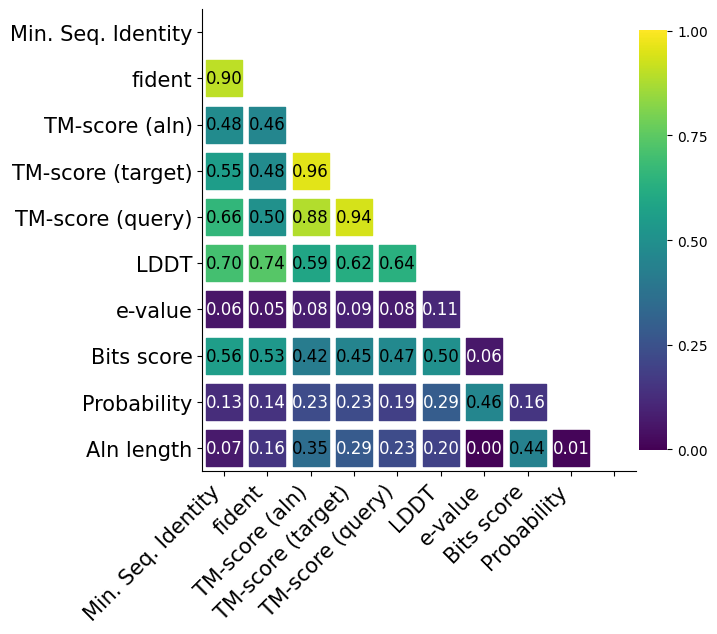

In [16]:
# Structural Similarity Metrics

f_spec = ['min_sequence_identity',
            'fident_struct',
            'alntmscore_struct', 'ttmscore_struct', 'qtmscore_struct',
            'lddt_struct', 
            'evalue_struct', 'bits_struct',
            'prob_struct', 'alnlen_struct',
            ]

# Calculate the correlation matrix
corr_matrix = paralog_pairs[f_spec].corr().abs()

# Prepare data for the heatmap
corr = corr_matrix.reset_index().melt(id_vars='index')
corr.columns = ['x', 'y', 'value']

# Plot the heatmap
heatmap(
    fig_size = 6,
    scale = 700,
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value'],
    x_labels=f_spec,
    y_labels=f_spec,
    feature_labels=feature_labels
)

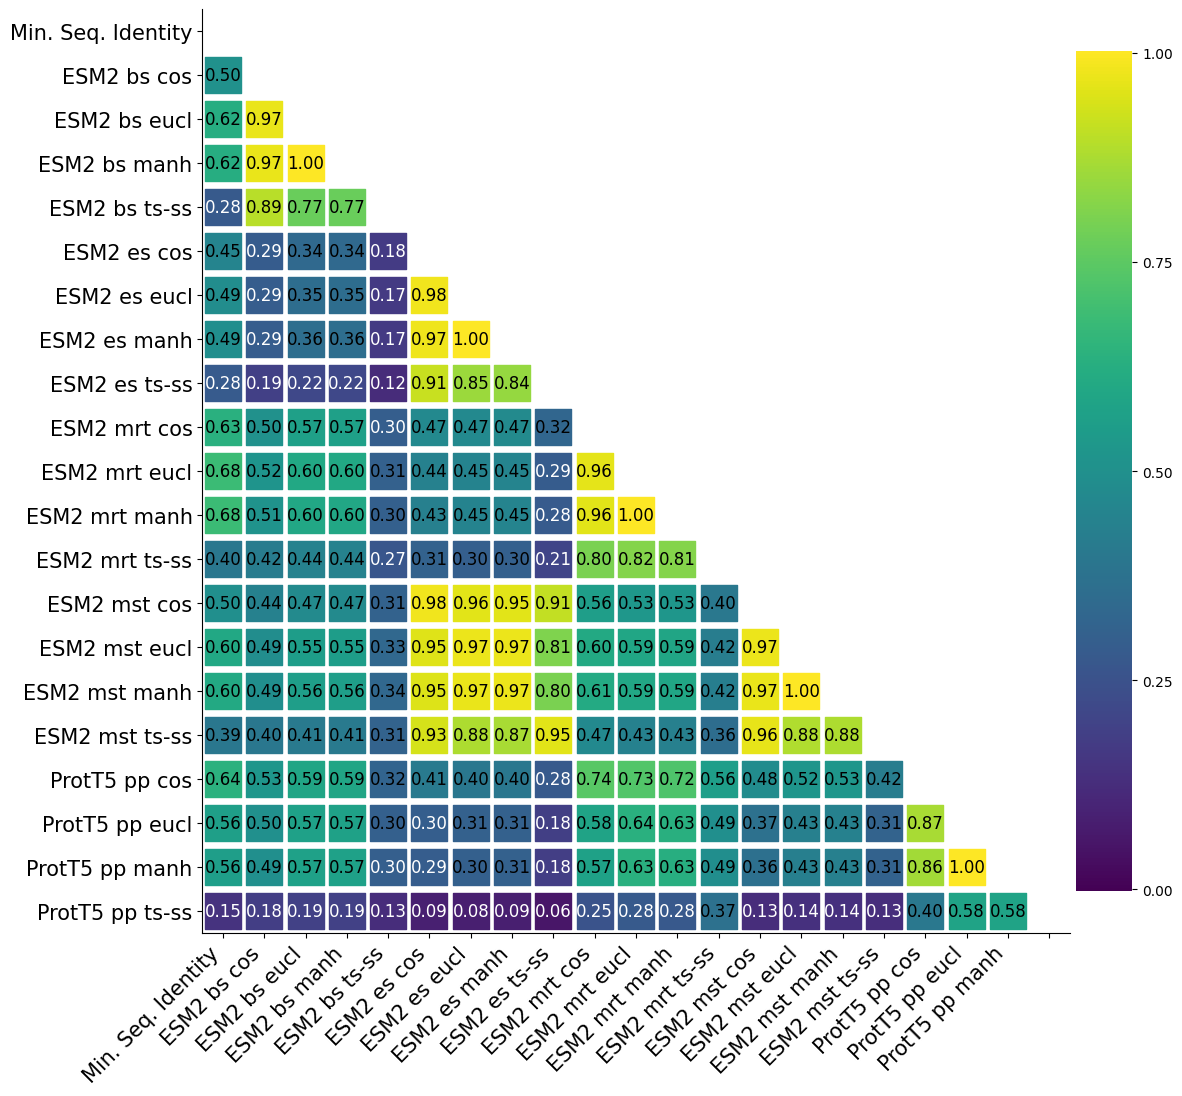

In [17]:
# Protein Language Model Embeddings Metrics

f_spec = ['min_sequence_identity',
            'esm2_beginning_of_sequence_cosine',
            'esm2_beginning_of_sequence_euclidean','esm2_beginning_of_sequence_manhattan', 'esm2_beginning_of_sequence_ts_ss',
            'esm2_end_of_sequence_cosine',
            'esm2_end_of_sequence_euclidean', 'esm2_end_of_sequence_manhattan','esm2_end_of_sequence_ts_ss',
            'esm2_mean_of_residue_tokens_cosine',
            'esm2_mean_of_residue_tokens_euclidean', 'esm2_mean_of_residue_tokens_manhattan','esm2_mean_of_residue_tokens_ts_ss',
            'esm2_mean_of_special_tokens_cosine',
            'esm2_mean_of_special_tokens_euclidean','esm2_mean_of_special_tokens_manhattan', 'esm2_mean_of_special_tokens_ts_ss',
            'ProtT5_per-protein_cosine', 
            'ProtT5_per-protein_euclidean', 'ProtT5_per-protein_manhattan', 'ProtT5_per-protein_ts_ss',  
                    ]

# Calculate the correlation matrix
corr_matrix = paralog_pairs[f_spec].corr().abs()

# Prepare data for the heatmap
corr = corr_matrix.reset_index().melt(id_vars='index')
corr.columns = ['x', 'y', 'value']

# Plot the heatmap
heatmap(
    fig_size = 12,
    scale = 700,
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value'],
    x_labels=f_spec,
    y_labels=f_spec,
    feature_labels=feature_labels
)


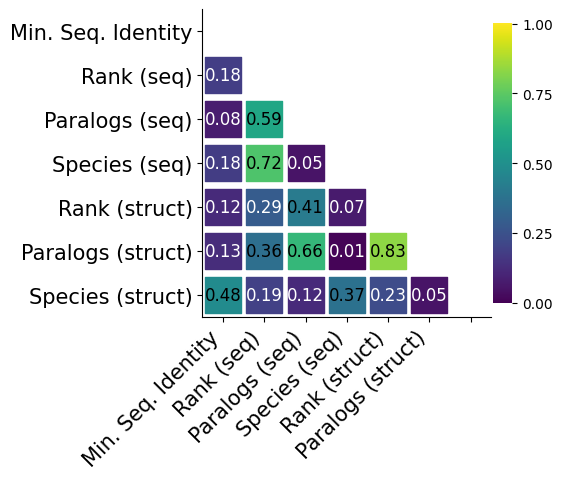

In [20]:
# Similarity Search Metrics

f_spec = ['min_sequence_identity',
            'rank_seq', 'selfSP_seq', 'taxid_seq' ,
            'rank_struct', 'selfSP_struct', 'taxid_struct', 
            ]

# Calculate the correlation matrix
corr_matrix = paralog_pairs[f_spec].corr().abs()

# Prepare data for the heatmap
corr = corr_matrix.reset_index().melt(id_vars='index')
corr.columns = ['x', 'y', 'value']

# Plot the heatmap
heatmap(
    fig_size = 4,
    scale = 700,
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value'],
    x_labels=f_spec,
    y_labels=f_spec,
    feature_labels=feature_labels
)

# Define the label to use as the function to predict

## Using `fet_ppi_overlap` to approximate functional divergence

In [37]:
# Bioplex annotations
BioPlex_paralog_pairs = paralog_pairs.copy(deep=True) 

# Use BIOPLEX HEK293T PPI data (unbiased in term of expression)
fn_bioplex_ppi = Path('/Users/olivierdennler/Documents/data/SLI_2023/paralog_SL_prediction-master/local_data/processed/paralog_features/ppi_bioplexHEK293T_features.csv').resolve()
bioplex_ppi = pd.read_csv(fn_bioplex_ppi)

# Rename to avoid conflict
BioPlex_paralog_pairs = BioPlex_paralog_pairs.rename(columns={'n_total_ppi': 'n_total_ppi_biogrid'})
BioPlex_paralog_pairs = BioPlex_paralog_pairs.rename(columns={'fet_ppi_overlap': 'fet_ppi_overlap_biogrid'})
BioPlex_paralog_pairs = BioPlex_paralog_pairs.rename(columns={'n_A1_ppi': 'n_A1_ppi_biogrid'})
BioPlex_paralog_pairs = BioPlex_paralog_pairs.rename(columns={'n_A2_ppi': 'n_A2_ppi_biogrid'})
BioPlex_paralog_pairs = BioPlex_paralog_pairs.rename(columns={'A1_ppi': 'A1_ppi_biogrid'})
BioPlex_paralog_pairs = BioPlex_paralog_pairs.rename(columns={'A2_ppi': 'A2_ppi_biogrid'})
bioplex_ppi = bioplex_ppi.rename(columns={'fet_ppi_overlap': 'fet_ppi_overlap_BIOPLEX'})
bioplex_ppi = bioplex_ppi.rename(columns={'interact': 'interact_BIOPLEX'})

# Merge with the main dataset
BioPlex_paralog_pairs = pd.merge(BioPlex_paralog_pairs, bioplex_ppi, how='left', left_on=['A1_entrez','A2_entrez'], right_on = ['A1_entrez','A2_entrez'])
print('Num pairs (after merging with Bioplex PPI):', BioPlex_paralog_pairs.shape[0])

# Drop rows with NaN in fet_ppi_overlap BIOPLEX
BioPlex_paralog_pairs = BioPlex_paralog_pairs.dropna(subset=['fet_ppi_overlap_BIOPLEX'])

# Change fet_ppi_overlap to use for using it directly on the rest of the code
BioPlex_paralog_pairs['fet_ppi_overlap'] = BioPlex_paralog_pairs['fet_ppi_overlap_BIOPLEX']

# Print the number of rows after dropping NaN
print(f"Number of rows after dropping NaN: {BioPlex_paralog_pairs.shape[0]}")
BioPlex_paralog_pairs.loc[:, ['sorted_gene_pair', 'fet_ppi_overlap', 'fet_ppi_overlap_BIOPLEX', 'fet_ppi_overlap_biogrid'
                        ]]


Num pairs (after merging with Bioplex PPI): 104303
Number of rows after dropping NaN: 104303


,sorted_gene_pair,fet_ppi_overlap,fet_ppi_overlap_BIOPLEX,fet_ppi_overlap_biogrid
0,FCAR_GP6,0.0,0.0,5.465282
1,A1BG_IGSF1,0.0,0.0,0.000000
2,FCAR_IGSF1,0.0,0.0,0.000000
3,GP6_IGSF1,0.0,0.0,0.000000
4,FCAR_KIR2DL1,0.0,0.0,0.000000
...,...,...,...,...
104298,ZSWIM4_ZSWIM6,0.0,0.0,6.640965
104299,ZSWIM5_ZSWIM6,0.0,0.0,0.000000
104300,ZSWIM4_ZSWIM8,0.0,0.0,2.022481
104301,ZSWIM5_ZSWIM8,0.0,0.0,0.000000


In [38]:

# Define thresholds
hit_thres = -np.log10(0.05/int(BioPlex_paralog_pairs.shape[0]))
non_hit_thres = -np.log10(0.05)

print(f'Hit threshold: {hit_thres}')
print(f'Non-hit threshold: {non_hit_thres}')

# Build a functional divergence column
# Initialize the new column with NaNs
BioPlex_paralog_pairs['same_func_ppi'] = np.nan
# Apply conditions
BioPlex_paralog_pairs.loc[BioPlex_paralog_pairs['fet_ppi_overlap'] >= hit_thres, 'same_func_ppi'] = True
BioPlex_paralog_pairs.loc[BioPlex_paralog_pairs['fet_ppi_overlap'] <= non_hit_thres, 'same_func_ppi'] = False
        
# Count the occurrences of True, False, and calculate the number of NaN values
true_count = BioPlex_paralog_pairs['same_func_ppi'].sum()  # True values are treated as 1
false_count = len(BioPlex_paralog_pairs) - true_count - BioPlex_paralog_pairs['same_func_ppi'].isna().sum()  # Total length minus True and NaN
nan_count = BioPlex_paralog_pairs['same_func_ppi'].isna().sum()
# Print the distribution
print(f"In the column 'same_func_ppi', there are {true_count} True values, {false_count} False values, and {nan_count} NaN values.")

# Drop rows with NaN in same_func_ppi
BioPlex_paralog_pairs = BioPlex_paralog_pairs.dropna(subset='same_func_ppi')
# Insure it is a boolean feature
BioPlex_paralog_pairs['same_func_ppi'] = BioPlex_paralog_pairs['same_func_ppi'].astype(bool)
print('Num same function (ppi based):', sum(BioPlex_paralog_pairs.same_func_ppi), '/', BioPlex_paralog_pairs.shape[0])

# Save Dataset
BioPlex_paralog_pairs.to_csv(f'ens111_human_BioPlex.csv', index=False)

Hit threshold: 6.319326795602579
Non-hit threshold: 1.3010299956639813
In the column 'same_func_ppi', there are 3515 True values, 92775 False values, and 8013 NaN values.


/var/folders/3q/2xywjjx10gz19vlr9tn3r25m0000gn/T/ipykernel_5459/48318803.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  BioPlex_paralog_pairs.loc[BioPlex_paralog_pairs['fet_ppi_overlap'] >= hit_thres, 'same_func_ppi'] = True


Num same function (ppi based): 3515 / 96290


## Using `Synthetic Lethality` (DepMap) to approximate functional divergence

In [39]:
# Use DepMap to define SL pairs
DepMap_paralog_pairs = paralog_pairs.copy(deep=True) 

fn_depmap_pairs = Path('/Users/olivierdennler/Documents/data/SLI_2023/paralog_SL_prediction-master/local_data/results/depmap_pairs_ens111_seq00_fs2000.csv').resolve()

# training dataset
depmap_pairs = pd.read_csv(fn_depmap_pairs)

# Merge with the main dataset
DepMap_paralog_pairs = pd.merge(DepMap_paralog_pairs, depmap_pairs, how='left', left_on=['sorted_gene_pair'], right_on = ['sorted_gene_pair'])
print('Num pairs (after merging with DepMap SL pairs):', DepMap_paralog_pairs.shape[0])

# Drop rows with NaN in depmap
DepMap_paralog_pairs = DepMap_paralog_pairs.dropna(subset=['SL'])

# Print the number of rows after dropping NaN
print(f"Number of rows after dropping SL NaN: {depmap_pairs.shape[0]}")
print('Num SL:', sum(depmap_pairs.SL), '/', depmap_pairs.shape[0])

# Save Datasets
DepMap_paralog_pairs.to_csv(f'ens111_human_SL.csv', index=False)


Num pairs (after merging with DepMap SL pairs): 104303
Number of rows after dropping SL NaN: 26635
Num SL: 124 / 26635


## Using `BPO, MFO, CCO` GO semantic similarity to approximate functional divergence

In [40]:

# For GO as labels

fn_gogo_features_pairs = Path('/Users/olivierdennler/Documents/data/SLI_2023/GO/gogo_ens111_human_data.csv').resolve()
# gogo GO semantic similarities
go_features = pd.read_csv(fn_gogo_features_pairs)
paralog_pairs = pd.merge(paralog_pairs.copy(deep=True) , go_features, how='left', on='sorted_gene_pair', suffixes=('', '_y'))
paralog_pairs.drop(paralog_pairs.filter(regex='_y$').columns, axis=1, inplace=True)


def build_go_dataset(paralog_pairs, go_t):
    '''
    Build a labelled dataset where paralog pairs are annotated has sharing common function or not
    Based on GO semantic distances 
    go_t being an ontology category among BPO, CCO and MFO
    '''

    print(f'=> Builfing {go_t} Gene Ontology dataset ...')

    # Drop rows with NaN for GO term
    paralog_pairs = paralog_pairs.dropna(subset=go_t)

    # Use define thres / based on https://github.com/MEGA-GO/MegaGO
    low_threshold, high_threshold = 0.3, 0.9
    print(f'Low threshold: {low_threshold}')
    print(f'High threshold: {high_threshold}')

    # Initialize the new column with NaNs
    paralog_pairs['same_func_go'] = np.nan

    # Assign True to the top 10% values
    paralog_pairs.loc[paralog_pairs[go_t] >= high_threshold, 'same_func_go'] = True

    # Assign False to the bottom 10% values
    paralog_pairs.loc[paralog_pairs[go_t] <= low_threshold, 'same_func_go'] = False

    # The rest will remain NaN as initialized

    # Count the occurrences of True, False, and calculate the number of NaN values
    true_count = paralog_pairs['same_func_go'].sum()  # True values are treated as 1
    false_count = len(paralog_pairs) - true_count - paralog_pairs['same_func_go'].isna().sum()  # Total length minus True and NaN
    nan_count = paralog_pairs['same_func_go'].isna().sum()
    # Print the distribution
    print(f"In the column 'same_func_go', there are {true_count} True values, {false_count} False values, and {nan_count} NaN values.")

    # Drop rows with NaN in same_func_ppi
    paralog_pairs = paralog_pairs.dropna(subset='same_func_go')
    # Insure it is a boolean feature
    paralog_pairs['same_func_go'] = paralog_pairs['same_func_go'].astype(bool)
    print(f'Num same function ({go_t} based):', sum(paralog_pairs.same_func_go), '/', paralog_pairs.shape[0])

    # Use it as label to predict 
    paralog_pairs['same_func_ppi'] = paralog_pairs['same_func_go']

    # Return the newly built dataset
    return paralog_pairs




# Build one dataset for each 
BPO_paralog_pairs = build_go_dataset(paralog_pairs, 'BPO')
MFO_paralog_pairs = build_go_dataset(paralog_pairs, 'MFO')
CCO_paralog_pairs = build_go_dataset(paralog_pairs, 'CCO')

# Save Datasets
BPO_paralog_pairs.to_csv(f'ens111_human_BPO.csv', index=False)
MFO_paralog_pairs.to_csv(f'ens111_human_MFO.csv', index=False)
CCO_paralog_pairs.to_csv(f'ens111_human_CCO.csv', index=False)


=> Builfing BPO Gene Ontology dataset ...
Low threshold: 0.3
High threshold: 0.9
In the column 'same_func_go', there are 967 True values, 19075 False values, and 13179 NaN values.
Num same function (BPO based): 967 / 20042
=> Builfing MFO Gene Ontology dataset ...
Low threshold: 0.3
High threshold: 0.9
In the column 'same_func_go', there are 9382 True values, 4898 False values, and 37886 NaN values.
Num same function (MFO based): 9382 / 14280
=> Builfing CCO Gene Ontology dataset ...
Low threshold: 0.3
High threshold: 0.9
In the column 'same_func_go', there are 5035 True values, 4765 False values, and 32297 NaN values.
Num same function (CCO based): 5035 / 9800


/var/folders/3q/2xywjjx10gz19vlr9tn3r25m0000gn/T/ipykernel_5459/2759597748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paralog_pairs['same_func_go'] = np.nan
/var/folders/3q/2xywjjx10gz19vlr9tn3r25m0000gn/T/ipykernel_5459/2759597748.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  paralog_pairs.loc[paralog_pairs[go_t] >= high_threshold, 'same_func_go'] = True
/var/folders/3q/2xywjjx10gz19vlr9tn3r25m0000gn/T/ipykernel_5459/2759597748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer